# Imports

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.io import gfile


#Local Imports 
import config 
import estimators
import data_kaggle as kd
import icetea_feature_extraction as fe
import icetea_data_simulation as ds 
import utils 


path_root = '/content/drive/MyDrive/ColabNotebooks/data'
path_images_png = 'icetea_png/train'
path_tfrecords = 'icetea_tfr/'
path_tfrecords_new = 'new_data_small/'#'icetea_newdata/' 
path_features = 'icetea_features/'
path_results = 'icetea_kaggle_results/'

b = 20 #number of repetitions of each setting

# Predix of images used to train feature extractor  (not used for causal inf.)
prefix_train = 'train' 
# Prefix of images with features extracted (used for causal inf.)
prefix_extract = 'extract'
# Prefix of images after join (images + simulated t and y )
prefix_trainNew = prefix_output = 'trainNew'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

paths_list = [path_images_png, path_tfrecords, path_tfrecords_new, path_features, path_results]
paths_list = [os.path.join(path_root, path) for path in paths_list]

for path in paths_list:
  assert os.path.isdir(path), path+': Folder does not exist!'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Extractor and Data Simulation



## 1. From .PNG to TFRecord

Kaggle datasets contain the individual images and a csv file with targets. This first section will combine the images with the csv and save as TFRecord. 


Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 0 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 1 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 2 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 3 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 4 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 5 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 6 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 7 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 8 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 9 of 12...

Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/: 10 of 12...

Writing TFRecord - /content/drive/MyDrive

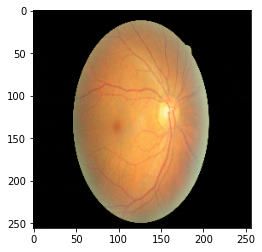

In [ ]:
# Saving images in TFRecord

#1) SAVE FILES AS TFRECORDS - run only once
paths = {
    'images':path_images_png, #folder
    'meta':'trainLabels.csv', #file
    'write_in':path_tfrecords, #folder
    'root': path_root,
}


#kd.write_images_as_tfrecord(paths=paths, 
#                            prefix_train=prefix_train,
#                            prefix_extract=prefix_extract,
#                            )


#CHECK IF FILE EXISTS AND WORKS 
config_feat_extract = {'path_tfrecords':os.path.join(paths['root'], 
                                                     paths['write_in']), 
                       'batch_size': 16}
dataset_train, dataset_val = kd.build_datasets_feature_extractor(
    config_feat_extract, 
    prefix_train=prefix_train, 
    prefix_extract=prefix_extract,
    type='TrainFeatureExtractor'
    )
batch = next(iter(dataset_train))
plt.imshow(batch[0][0])
print('You should see an image')

##2. Feature Extraction 

This next part will read some of the images (saved as train*.tfrec) to train an image model used to predict the original target from the Kaggle Competition. 

Then, using the remaining images (extract*.tfrec), it will created a features.csv file under the 'output' folder, which contain the features used to create the simulations. 

In [ ]:
#2)Extracting features: it creates a new csv file called features.csv
model_config={
  'path_tfrecords': os.path.join(path_root, path_tfrecords), 
  'batch_size': 16,
  'path_features': os.path.join(path_root, path_features), 
  'input_shape':[128, 128],
  'num_classes':5, 
  'backbone_drop_rate':0.25,
  'optimizer':'adam',
  'learning_rate':0.0001,
  'steps_per_epoch':5, 
  'epochs':10,
  'hidden_size': 64
}

model = fe.extract_hx(model_config)

['/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train00-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train01-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train02-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train03-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train04-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train05-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train06-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train07-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train08-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train09-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train10-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/train11-328.tfrec']
['/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract00-1024.tfrec', '/content

## 3. Simulations

Reads the features.csv file, and simulates treatment assigment and outcome. As we don't have any other features to use as outcome, both will be fully simulated (Light ICETEA). 

Below, you can control the knobs and which knobs you want to explore. 

All the simulations are merged together under joined_simulations.csv and true_tau.csv contain the true values. 


In [ ]:
#3) Creates the simulations - first reads the saved csv file with the features extracted 
config_sim = {
    'path_features':os.path.join(path_root, path_features),
    'b':b
}
features_file = pd.read_csv(config_sim['path_features']+'features.csv')
print('features - shape ', features_file.shape)

# Generate the simulations - there are three different settings, one for each knob
output1 = ds.generate_simulations(path_root=config_sim['path_features'],
                              output_name='simulations',
                              features= features_file, # pd.DataFrame(),
                              b=config_sim['b'],
                              knob_o=False,  # overlap
                              knob_h=False,  # heterogeneity
                              knob_s=True)


output2 = ds.generate_simulations(path_root=config_sim['path_features'],
                              output_name='simulations',
                              features= features_file, # pd.DataFrame(),
                              b=config_sim['b'],
                              knob_o=False,  # overlap
                              knob_h=True,  # heterogeneity
                              knob_s=False)

output3 = ds.generate_simulations(path_root=config_sim['path_features'],
                              output_name='simulations',
                              features= features_file, # pd.DataFrame(),
                              b=config_sim['b'],
                              knob_o=True,  # overlap
                              knob_h=False,  # heterogeneity
                              knob_s=False)


run_index= ds.organizing_simulations(path_features=config_sim['path_features'])


features - shape  (23534, 2305)
Joining simulations:


In [ ]:
path_simulations = os.path.join(path_root,path_features,'joined_simulations.csv')
simulations = pd.read_csv(path_simulations)
print(simulations.shape)
simulations.head()


(23534, 1201)


,images_id,sim_ks0_b0_0.1_0.5_0.5-pi,sim_ks0_b0_0.1_0.5_0.5-mu1,sim_ks0_b0_0.1_0.5_0.5-mu0,sim_ks0_b0_0.1_0.5_0.5-y,sim_ks1_b0_0.5_0.5_0.5-pi,sim_ks1_b0_0.5_0.5_0.5-mu1,sim_ks1_b0_0.5_0.5_0.5-mu0,sim_ks1_b0_0.5_0.5_0.5-y,sim_ks2_b0_1_0.5_0.5-pi,...,sim_ko2_b19_1_0.5_0.5-mu0,sim_ko2_b19_1_0.5_0.5-y,sim_ko3_b19_1_0.75_0.5-pi,sim_ko3_b19_1_0.75_0.5-mu1,sim_ko3_b19_1_0.75_0.5-mu0,sim_ko3_b19_1_0.75_0.5-y,sim_ko4_b19_1_1_0.5-pi,sim_ko4_b19_1_1_0.5-mu1,sim_ko4_b19_1_1_0.5-mu0,sim_ko4_b19_1_1_0.5-y
0,20547_left,0,1.508729,1.737551,1.737551,1,1.473225,1.719257,1.473225,0,...,1.729809,1.484374,0,1.530055,1.758477,1.758477,1,1.494330,1.732750,1.494330
1,35166_right,1,1.422291,1.641788,1.422291,0,1.386034,1.630064,1.630064,1,...,1.627705,1.627705,0,1.444287,1.658898,1.658898,0,1.409525,1.641079,1.641079
2,17207_right,0,1.563000,1.799190,1.799190,1,1.524244,1.777120,1.524244,1,...,1.792868,1.792868,0,1.588194,1.819289,1.819289,0,1.549910,1.794386,1.794386
3,44148_left,1,1.421314,1.647830,1.421314,0,1.390708,1.623141,1.623141,1,...,1.632523,1.632523,0,1.443774,1.660055,1.660055,0,1.410559,1.640448,1.640448
4,30043_right,1,1.514764,1.746435,1.514764,0,1.477725,1.725583,1.725583,1,...,1.736602,1.736602,0,1.538278,1.767594,1.767594,0,1.500904,1.746073,1.746073


## 4. Join Simulations and TFRrecords

* Simulations: joined_simulations.csv file
* tfrecrods (features/extract*.tfrec)

The files saved in this step makes the dataset used to train the causal inference models. 

In [ ]:
#4) Join simulations and tfrecords
path_simulations = os.path.join(path_root,path_features,'joined_simulations.csv') # '/content/output/joined_simulations.csv'

 
ds.join_tfrecord_csv(path_simulations=path_simulations,
                      path_input=os.path.join(path_root, path_tfrecords), 
                      path_output=os.path.join(path_root, path_tfrecords_new), 
                      input_prefix=prefix_extract,
                      output_prefix=prefix_output)

simulations 23534 (23534, 1201)
tfrecord_input_filenames ['/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract00-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract01-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract02-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract03-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract04-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract05-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract06-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract07-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract08-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract09-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract10-1024.tfrec', '/content/drive/MyDrive/ColabNotebooks/data/icetea_tfr/extract11-1024.tfrec', '/cont

In [ ]:
prefix_output

'trainNew'

## 5. Double-check

The code below double-check if the images were saved properly. You shold see an image after running the next cell. 

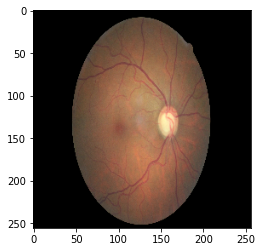

In [ ]:
seed = 'sim_ks0_b0_0.1_0.5_0.5'
param_data={
    'name':'kagle_retinal',
    'path_tfrecords':os.path.join(path_root, path_tfrecords_new),
    'prefix_train':prefix_output, 
    'image_size':[256,256],
    'batch_size': 2
}
data = utils.ImageData(seed, param_data)
data.make_plot()